# Imports

In [7]:
import os
import torch
from tqdm import tqdm
from random import randint
import numpy as np
import matplotlib.pyplot as plt
import gc

if not os.path.exists('data'):
    new_directory_path = "..\\..\\"
    os.chdir(new_directory_path)


from src.eval.eval_metrics import precision,recall,create_cls_targets, accuracy, eval_reg
from src.eval.eval_utils import plt_training_metrics, gather_best_metrics
from src.eval.vis_scanpath import draw_scanpath_mpl
from src.model.model_io import load_models_with_data
from src.training.training_utils import move_data_to_device, compute_loss


## Methods

In [2]:
def get_coords(idx, x,y, fixation_len, reg_out):
    x_coords = x[idx,:,:2].cpu().numpy().T
    y_coords = y[idx,:fixation_len[idx],:2].cpu().numpy().T
    reg_coords = reg_out[idx,:fixation_len[idx],:2].cpu().numpy().T
    x_coords = x_coords[:,::-1]
    y_coords = y_coords[:,::-1]
    reg_coords = reg_coords[:,::-1]
    return x_coords, y_coords, reg_coords

def batch_to_list(x, fixation_len = None):
    # convert from padded batch [B,T,F] to list of numpy arrays with shape [F,N]
    x_list = []
    for i in range(x.size(0)):
        l = 0
        if fixation_len is None:
            l = x.size(1)
        else:
            l = fixation_len[i]
        x_i = x[i,:l, :].cpu().numpy().T
        x_list.append(x_i)
    return x_list

def plot_classification_scores(cls_out,fixation_len, title="Classification Scores"):
    acum = np.zeros(7)
    count = 0
    skipped_count = 0
    for i in range(cls_out.shape[0]):
        cls_out_sample = cls_out[i]
        cls_out_sample = torch.sigmoid(cls_out_sample).cpu().numpy().T
        if fixation_len[i] < 3 or fixation_len[i] > cls_out_sample.shape[1]-4:
            skipped_count += 1
            continue
        acum += cls_out_sample[0,fixation_len[i]-3: fixation_len[i]+4 ]
        count +=1
    avg = acum / count
    image_data = avg.reshape(7, 1).T
    plt.figure(figsize=(7,1)) # Set the figure size to be tall and thin
    plt.imshow(image_data, cmap='gray', interpolation='nearest', aspect='auto')
    text_color = 'green' 
    for i in range(image_data.shape[0]):
        for j in range(image_data.shape[1]):
            score = image_data[i, j]
            
            plt.text(j, i, f'{score:.2f}', 
                     ha="center", va="center", color=text_color, fontsize=10)
    print(f'Skipped samples: {skipped_count} out of {cls_out.shape[0]}')
    plt.title(title)
    plt.xticks(range(7), [f'Token {i-3}' if i != 3 else 'END' for i in range(7)]) # Optional: keep y-axis labels for reference
    plt.yticks([])
    plt.show()
    
def invert_transforms(inputs, outputs, dataloader):
    pred_reg = outputs['reg']
    gt_reg = inputs['tgt']
    transforms = dataloader.path_dataset.transforms
    # reverse the transforms
    for transform in reversed(transforms):
        if transform.modify_y:
            pred_reg = transform.inverse(pred_reg)
            gt_reg = transform.inverse(gt_reg)
    outputs['reg'] = pred_reg
    inputs['tgt'] = gt_reg
    return inputs, outputs



# Eval

## Review Metrics

In [3]:

# ckpt_path = ['outputs\\2025-11-19\\18-48-14',
#              'outputs\\2025-11-27\\17-35-19',
#              'outputs\\2025-11-28\\12-28-42'
#              ]
ckpt_path = ['outputs\\2025-12-03\\17-10-55']

metric_path = [os.path.join(p, 'metrics.json') for p in ckpt_path]

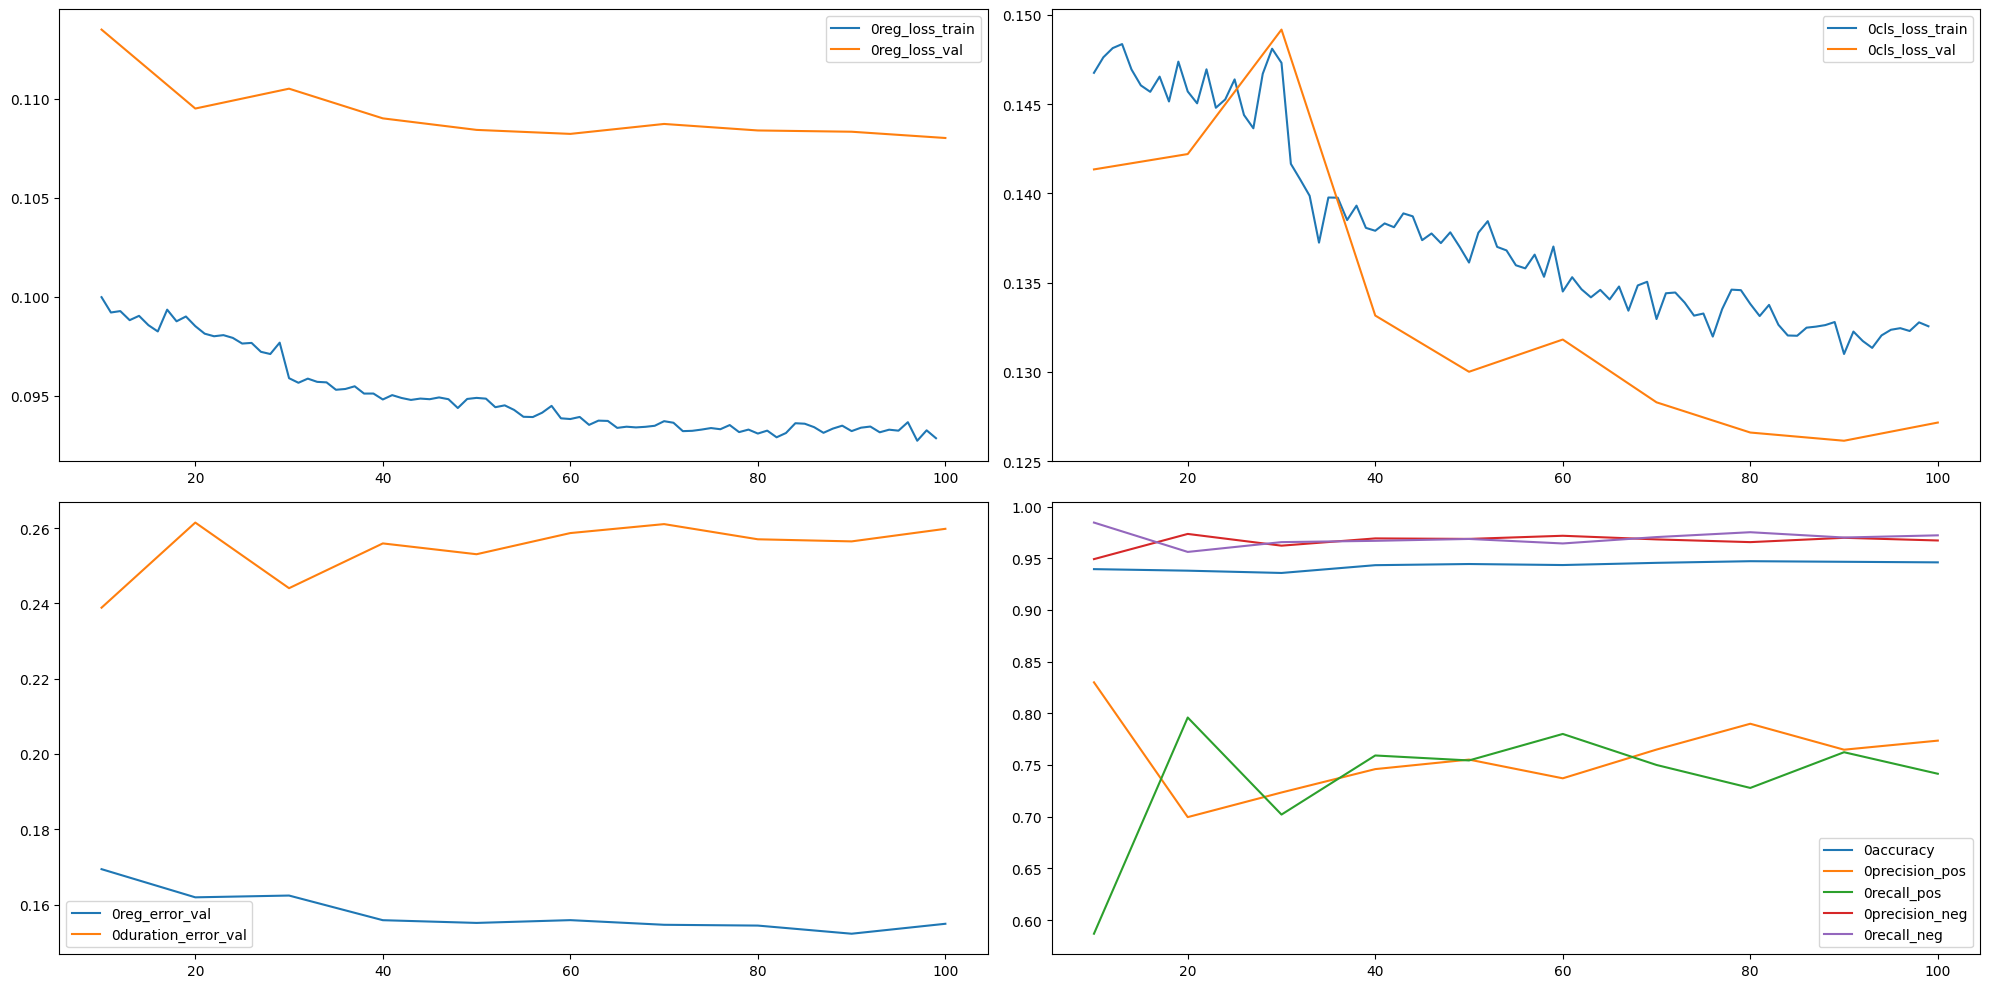

In [4]:
plt_training_metrics(metric_path, start_epoch=10)

In [5]:
ckpt_path = ['outputs\\2025-11-19\\18-48-14',
             'outputs\\2025-11-27\\17-35-19',
             'outputs\\2025-11-28\\12-28-42',
             'outputs\\2025-12-03\\17-10-55']

metric_path = [os.path.join(p, 'metrics.json') for p in ckpt_path]
gather_best_metrics(metric_path)

,epoch,reg_loss_train,reg_loss_val,cls_loss_train,cls_loss_val,accuracy,precision_pos,recall_pos,precision_neg,recall_neg,reg_error_val,duration_error_val
0,100,7607.521662,7566.260010,0.234150,0.233732,0.890130,0.741319,0.329663,0.913140,1.000000,NaN,NaN
1,100,8060.989434,6853.475754,0.262169,0.255997,0.887517,0.572673,0.119068,0.896838,1.000000,60.499606,68.711616
2,100,7479.535542,7927.933896,0.252484,0.254622,0.881869,0.587735,0.153930,0.892783,1.000000,68.865608,74.855592
3,100,0.092843,0.108017,0.132552,0.127158,0.947127,0.829949,0.795916,0.973512,0.984502,0.152242,0.238872


## Checkout Output

### Eval Just One Batch

In [ ]:
device = 'cpu'
inputs_outputs = []

models_and_data = load_models_with_data(ckpt_path)
for i, (model, _, _, test_dataloader) in enumerate(models_and_data):    
    print(f'Model {i}')
    model.eval()
    for batch in tqdm(test_dataloader):
        input = move_data_to_device(batch, device)
        with torch.no_grad():
            output = model(**input)
            inputs, outputs = invert_transforms(input, output, test_dataloader)
            compute_loss(input, output)
            inputs_outputs.append((inputs, outputs))
            reg_out, cls_out = outputs['reg'], outputs['cls']
            y, y_mask, fixation_len = inputs['tgt'], inputs['tgt_mask'], inputs['fixation_len']
            cls_targets = create_cls_targets(cls_out, fixation_len)
            print('accuracy: ',accuracy(cls_out, y_mask, cls_targets))
            print('precision_pos: ',precision(cls_out, y_mask, cls_targets))
            print('recall_pos: ',recall(cls_out, y_mask, cls_targets))
            print('precision_neg: ',precision(cls_out, y_mask, cls_targets, cls = 0))
            print('recall_neg: ',recall(cls_out, y_mask, cls_targets, cls = 0))
            reg_error, dur_error = eval_reg(reg_out, y, y_mask)
            print(f'Regression error (pixels): {reg_error:.4f}, Duration error ({dur_error:.4f})')
        break
    del model
    torch.cuda.empty_cache()
    gc.collect()
    

NameError: name 'models_and_data' is not defined

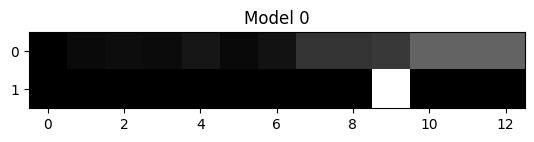

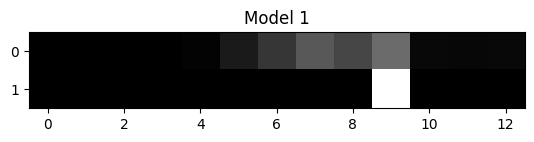

In [ ]:
idx = randint(0,40 - 1)
for i, out in enumerate(outputs):
    reg_out, cls_out = out
    cls_out_sample = cls_out[idx]
    cls_out_sample = torch.sigmoid(cls_out_sample).cpu().numpy().T
    cls_targets_sample = cls_targets[idx].cpu().numpy().T
    # vstack
    pair = np.vstack((cls_out_sample, cls_targets_sample)).T
    plt.imshow(pair.T, cmap='gray')
    plt.title(f'Model {i}')
    plt.show()

Skipped samples: 11 out of 128


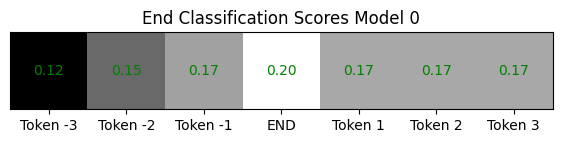

Skipped samples: 11 out of 128


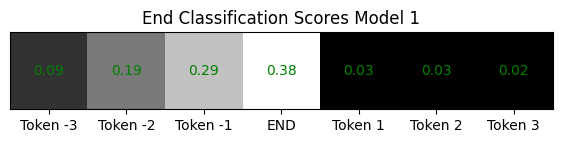

In [ ]:


# put the value in each pixel
for i, out in enumerate(outputs):
    reg_out, cls_out = out
    plot_classification_scores(cls_out, fixation_len, title=f"End Classification Scores Model {i}")

tensor(8)


c:\Users\ulloa\OneDrive\Desktop\Practicas\projectes\Dataset\src\vis_scanpath.py:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x[0], y[0], s=marker_size, c=end_color, zorder=5)


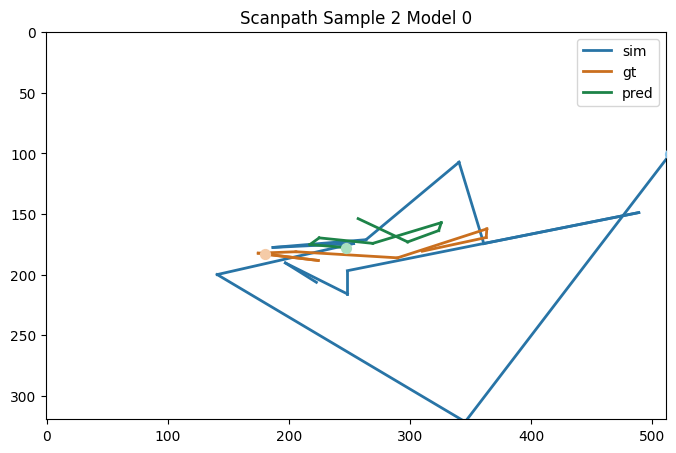

tensor(8)


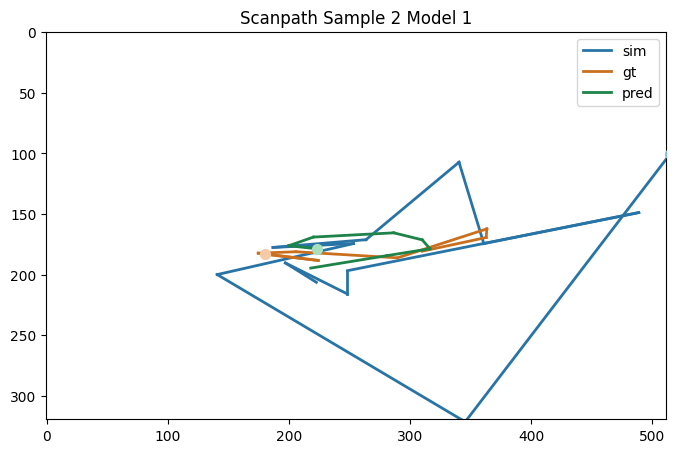

tensor(9)


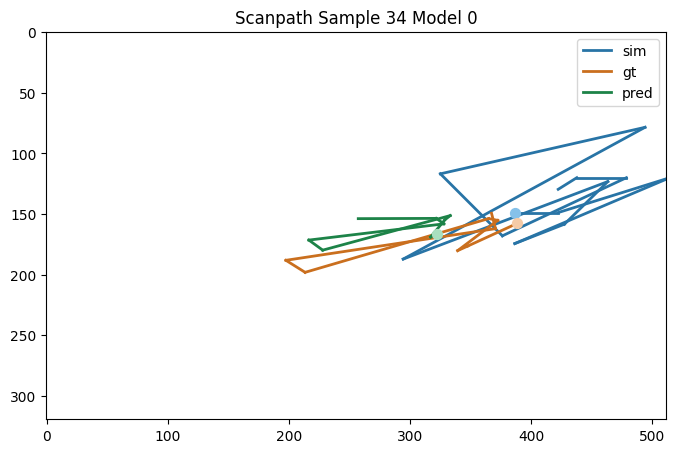

tensor(9)


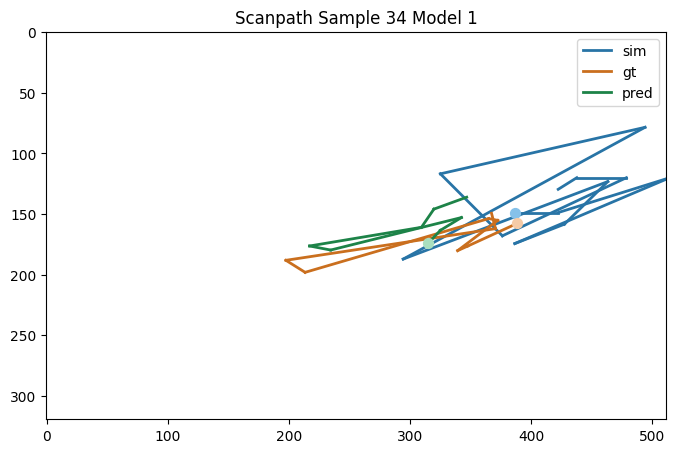

tensor(8)


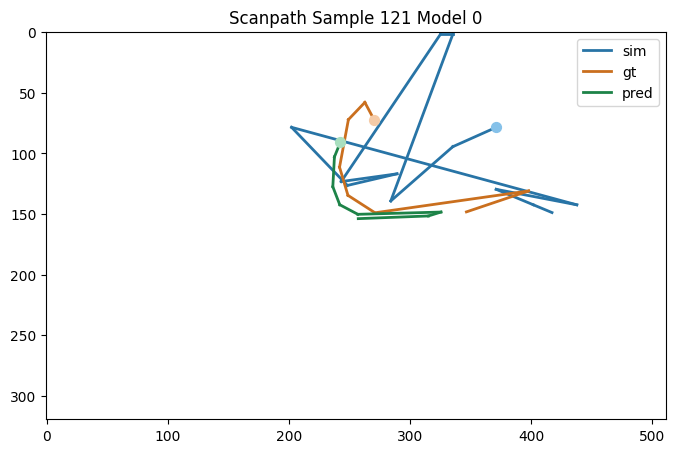

tensor(8)


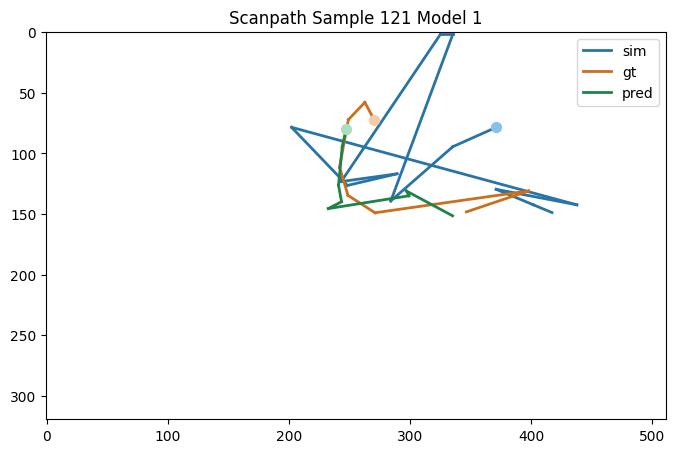

tensor(8)


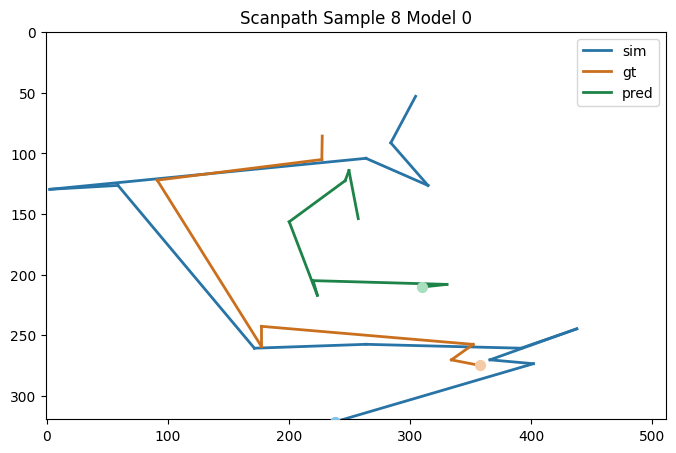

tensor(8)


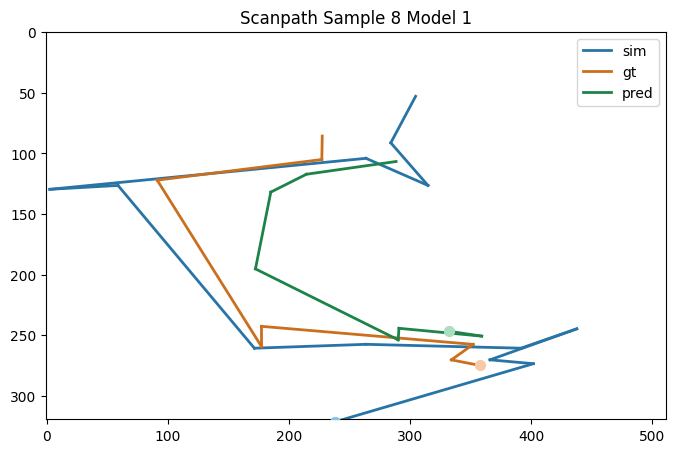

tensor(10)


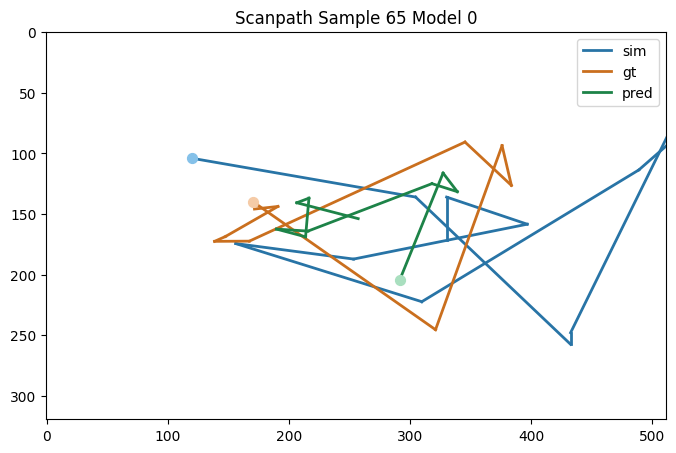

tensor(10)


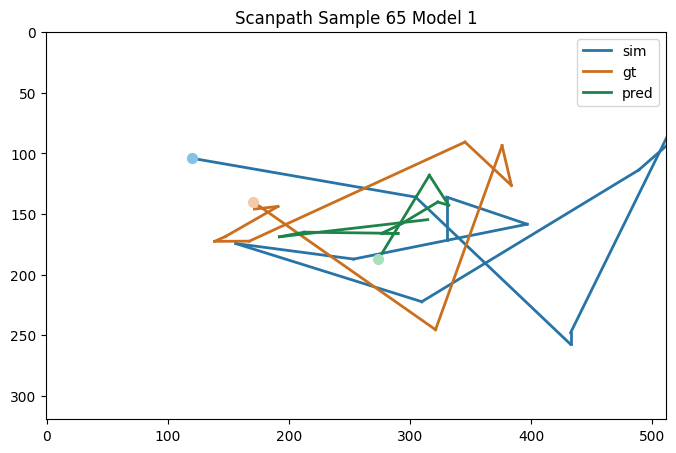

In [ ]:


for i in range(5):
    idx = randint(0,128-1)
    for j , out in enumerate(outputs):
        reg_out, cls_out = out
        x_coords, y_coords, reg_coords = get_coords(idx, x, y, fixation_len,reg_out)
        img = np.ones((320,512,3),dtype=np.uint8)*255

        label = ['sim', 'gt', 'pred']

        traj = [x_coords,
                y_coords, 
                reg_coords]
        traj_colors = [(40/255, 116/255, 166/255), # blue
                    (202/255, 111/255, 30/255), # orange
                    (29/255, 131/255, 72/255)] # green

        end_point_colors = [(133/255, 193/255, 233/255),
                            (245/255, 203/255, 167/255),
                            (169/255, 223/255, 191/255)]
        fig, ax = plt.subplots(figsize=(8,8))
        for traj, color, end_color, lbl in zip(traj, traj_colors, end_point_colors, label):
            ax = draw_scanpath_mpl(ax, traj[0],traj[1], color=color, end_color=end_color, label=lbl)

        print(fixation_len[idx])
        plt.title(f'Scanpath Sample {idx} Model {j}')
        plt.imshow(img)
        plt.legend()
        plt.savefig(f'Output/scanpath_{i}_model_{j}.png')
        plt.show()


### Eval Stats

In [25]:


with torch.no_grad():
    acc_list = []
    pre_pos_list = []
    rec_pos_list = []
    pre_neg_list = []
    rec_neg_list = []
    reg_list = []
    coord_error_list = []
    dur_error_list = []
    for i, model in enumerate(model_list):
        print(f'Model {i} Evaluation')
        model.eval()
        acc_acum = 0
        pre_pos_acum = 0
        rec_pos_acum = 0
        pre_neg_acum = 0
        rec_neg_acum = 0
        coord_error_acum = 0
        dur_error_acum = 0
        count = 0
        reg_results = []
        y_results = []
        x_results = []
        for batch in tqdm(test_dataloader):
                x,x_mask,y, y_mask, fixation_len = batch
                x = x.to(device=device)
                y = y.to(device=device)
                if x_mask is not None:
                    x_mask = x_mask.to(device = device)
                if y_mask is not None:
                    y_mask = y_mask.to(device = device)
                fixation_len = fixation_len.to(device = device)
                reg_out,cls_out = model(x,y, x_mask, y_mask)
                reg_results += batch_to_list(reg_out, fixation_len)
                y_results += batch_to_list(y, fixation_len)
                x_results += batch_to_list(x)
                cls_targets = create_cls_targets(cls_out, fixation_len)
                acc_acum += accuracy(cls_out, y_mask, cls_targets)
                pre_pos_acum += precision(cls_out, y_mask, cls_targets)
                rec_pos_acum += recall(cls_out, y_mask, cls_targets)
                pre_neg_acum += precision(cls_out, y_mask, cls_targets, cls = 0)
                rec_neg_acum += recall(cls_out, y_mask, cls_targets, cls = 0)
                coord_error, dur_error = eval_reg(reg_out, y, y_mask)
                coord_error_acum += coord_error.item()
                dur_error_acum += dur_error.item()
                count += 1
        reg_list.append(reg_results)
        coord_error_list.append(coord_error_acum/count)
        dur_error_list.append(dur_error_acum/count)
        acc_list.append(acc_acum/count)
        pre_pos_list.append(pre_pos_acum/count)
        rec_pos_list.append(rec_pos_acum/count)
        pre_neg_list.append(pre_neg_acum/count)
        rec_neg_list.append(rec_neg_acum/count)
x_list = [x_results,'sim', 1/16]
y_list = [y_results,'fixations', 1/16]




Model 0 Evaluation


100%|██████████| 28/28 [00:20<00:00,  1.36it/s]


Model 1 Evaluation


100%|██████████| 28/28 [00:23<00:00,  1.20it/s]


In [26]:
# plot evaluation metrics using pandas 
import pandas as pd
# Transpose the dataframe so models are columns and metrics are rows
metrics_df = pd.DataFrame({
    'Accuracy': acc_list,
    'Precision_Pos': pre_pos_list,
    'Recall_Pos': rec_pos_list,
    'Precision_Neg': pre_neg_list,
    'Recall_Neg': rec_neg_list,
    'Coord_Error': coord_error_list,
    'Dur_Error': dur_error_list
}, index=[f'Model_{i}' for i in range(len(acc_list))])
metrics_df = metrics_df.transpose()
metrics_df

,Model_0,Model_1
Accuracy,0.878708,0.891369
Precision_Pos,0.459829,0.617430
Recall_Pos,0.017578,0.280525
Precision_Neg,0.880417,0.907771
Recall_Neg,0.997468,0.975568
Coord_Error,75.630815,66.381780
Dur_Error,77.354207,74.663982


In [27]:
gaze_list = [x_list, y_list, *[[reg_list[i],f'pred {i}', 1/16] for i in range(len(reg_list))]]

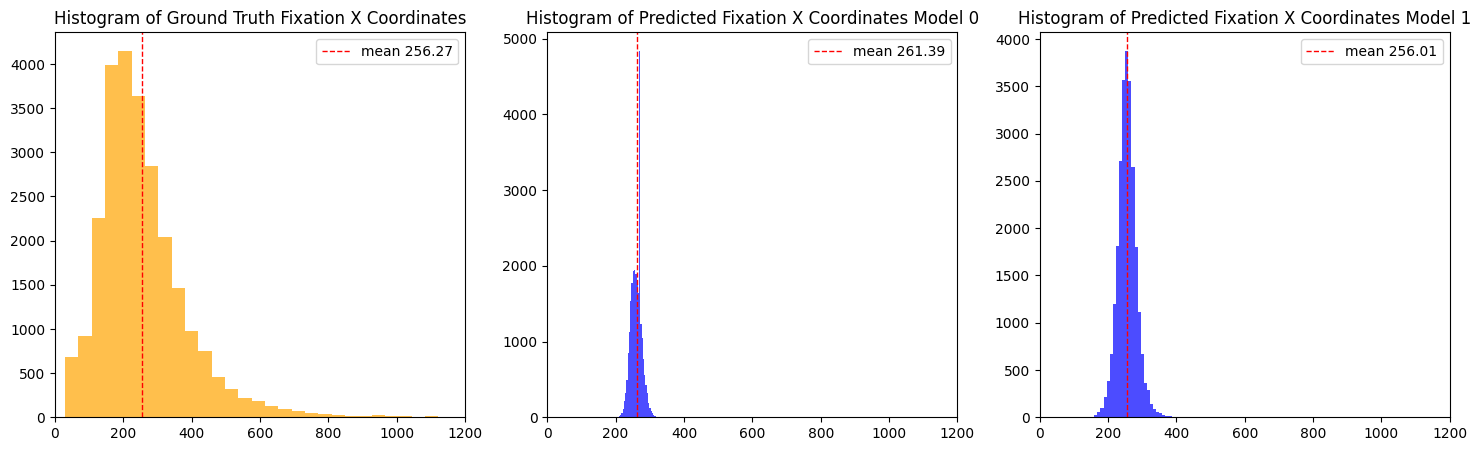

In [28]:
concatenated_y = np.concat([y[2] for y in y_results])

# plot a hist of each array in two subplots
fig, axs = plt.subplots(1,1 + len(reg_list), figsize=(6*(1 + len(reg_list)),  5))
concatenated_reg = np.concat([reg[2] for reg in reg_results])
axs[0].hist(concatenated_y, bins=30, color='orange', alpha=0.7)
axs[0].set_title('Histogram of Ground Truth Fixation X Coordinates')
axs[0].set_xlim(0, 1200)
axs[0].axvline(np.mean(concatenated_y), color='red', linestyle='dashed', linewidth=1, label = f'mean {np.mean(concatenated_y):.2f}')
axs[0].legend()
for i in range(len(reg_list)):
    concatenated_reg = np.concat([reg[2] for reg in reg_list[i]])
    axs[i+1].hist(concatenated_reg, bins=30, color='blue', alpha=0.7)
    axs[i+1].set_title(f'Histogram of Predicted Fixation X Coordinates Model {i}')
    axs[i+1].set_xlim(0, 1200)
    axs[i+1].axvline(np.mean(concatenated_reg), color='red', linestyle='dashed', linewidth=1, label = f'mean {np.mean(concatenated_reg):.2f}')
    axs[i+1].legend()
plt.show()

    


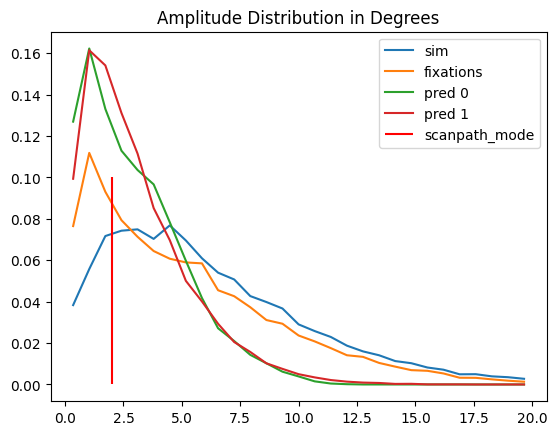

In [29]:
from src.eval_utils import plot_amplitude_dist, plot_angle_distribution, plot_autocorrelation, plot_consecutive_angles, plot_vector_dist, calculate_relative_vectors                        
plot_amplitude_dist([gaze[0] for gaze in gaze_list],
                    [gaze[1] for gaze in gaze_list],
                    [gaze[2] for gaze in gaze_list])

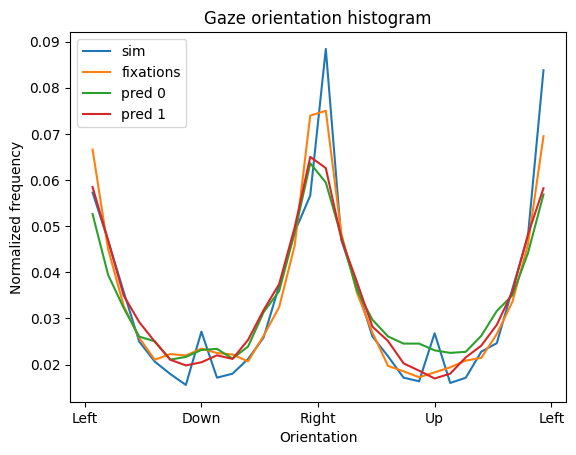

In [30]:
plot_angle_distribution([gaze[0] for gaze in gaze_list],
                    [gaze[1] for gaze in gaze_list])
plt.show()

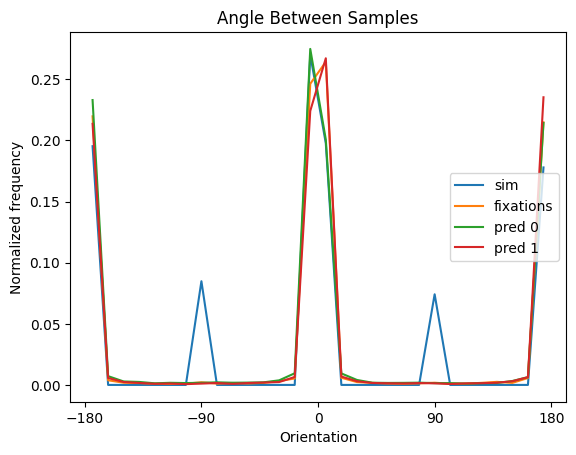

In [31]:
plot_consecutive_angles([gaze[0] for gaze in gaze_list],
                    [gaze[1] for gaze in gaze_list])
plt.show()

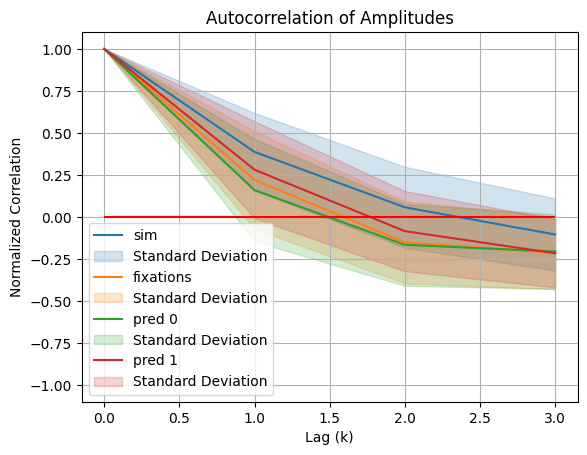

In [32]:
plot_autocorrelation([gaze[0] for gaze in gaze_list],
                    [gaze[1] for gaze in gaze_list], min_len=4)
plt.show()

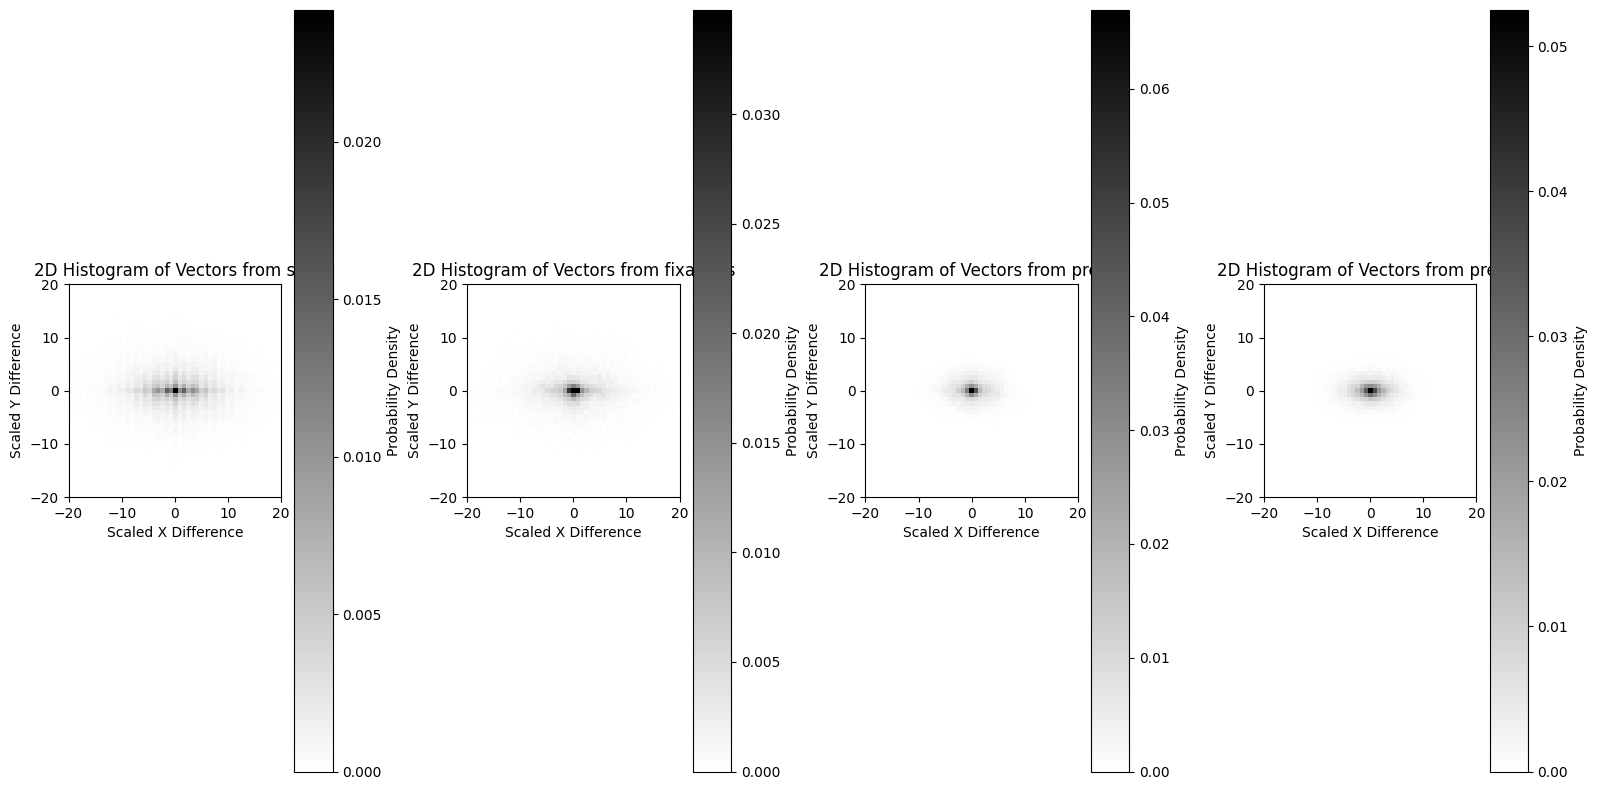

In [33]:
plot_vector_dist([[np.diff(gaze_sample[:2, :], axis=1) for gaze_sample in gaze[0]] for gaze in gaze_list],
                 [gaze[2] for gaze in gaze_list], 
                 [gaze[1] for gaze in gaze_list],)

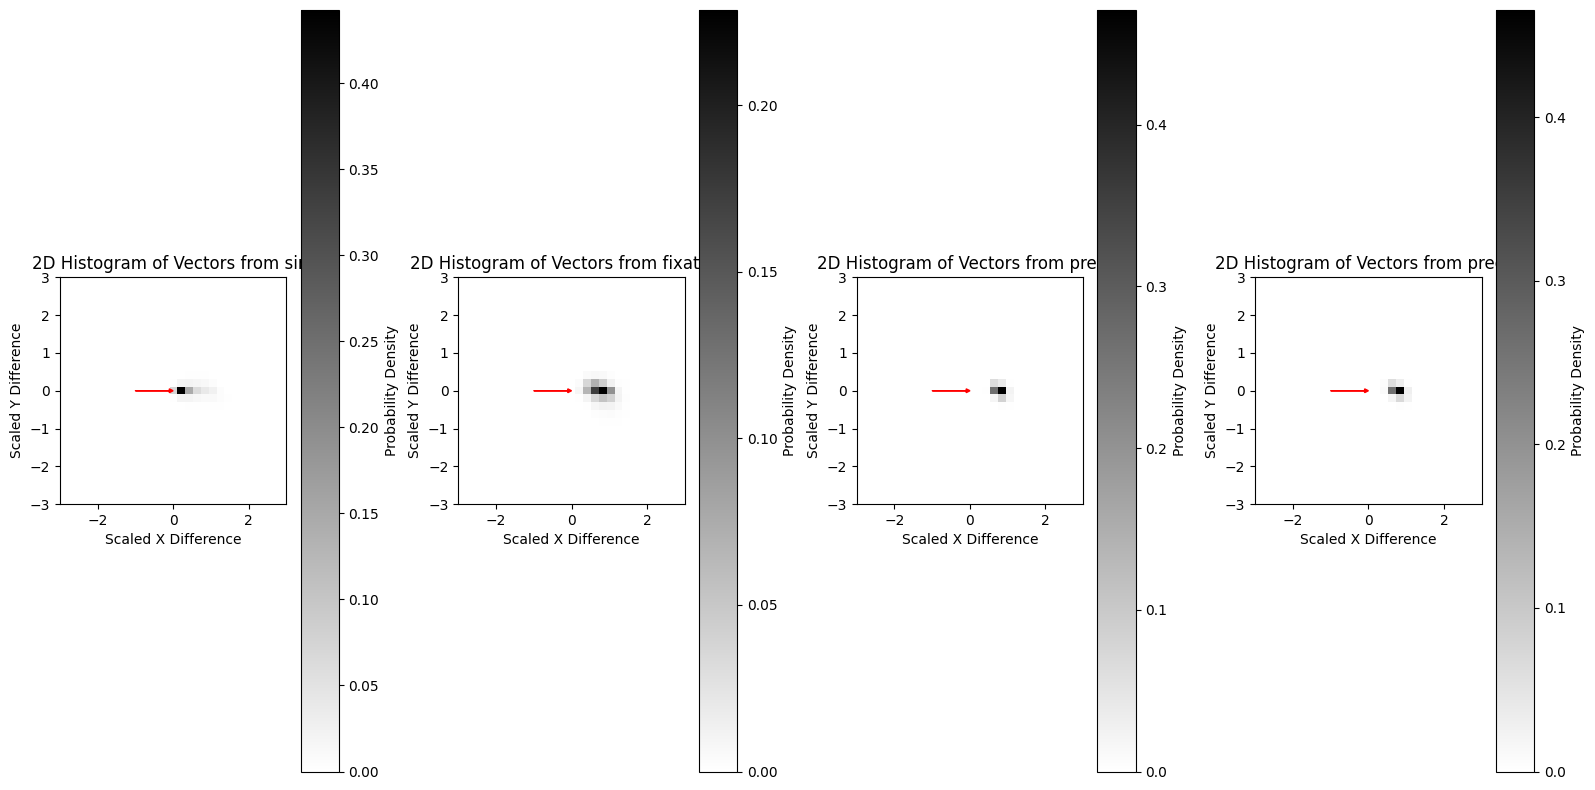

In [34]:
plot_vector_dist([[calculate_relative_vectors(gaze_sample) for gaze_sample in gaze[0]] for gaze in gaze_list],
                    [1 for _ in gaze_list],
                    [gaze[1] for gaze in gaze_list],-3,3,30, arrow= True)

plt.show()